In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpltools import color
import numpy as np
from scipy import optimize
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import ROIproc as RP

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('ROI processing tutorial started')

INFO:root:ROI processing tutorial started


# Processing Regions Of Interest (ROIs)

```CorrMaps``` class is designed to compute correlations with maximum spatial resolution. This comes at the expense of computation time and of output size. When maximum spatial resolution is not the priority, it may be convenient to average the intensity correlation on fewer, extended Regions Of Interest (ROIs). This is done by the ```ROIproc``` class.

### Defining a set of ROIs

To define a set of ROIs, the fist thing required is a reference system. Both cartesian and polar coordinates are supported, and can be generated, for a given image shape, by calling:

```python
grid = RP.PixelCoordGrid(shape, extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
```

where:
- ```shape``` is the shape of the map, in number of pixels ```[num_rows, num_cols]```
- ```extent``` is the cartesian extent of the mapping, in physical units ```[x_left, x_right, y_bottom, y_top]```. They can eventually be reversed (e.g. ```x_right<x_left```). If it is set to ```None```, it takes the default value ```[0, shape[1], shape[0], 0]```
- ```center``` is the origin of the coordinate system, in physical units
- ```angle``` is a parameter eventually rotating the coordinate system by a given angle, in radians. For cartesian coordinates, ```angle=0``` means $(x', y')=(x, y)$, whereas ```angle=pi/2``` means $(x', y')=(y, -x)$. For polar coordinates, ```angle=0``` means $\theta=0$ along $+x$, whereas ```angle=pi/2``` means $\theta=0$ along $+y$ (note: this means downwards if ```indexing='xy'```)
- ```coords``` is the choice of the coordinate system: set it to ```['cartesian'|'polar']``` to return ```[x,y]``` or ```[r,theta]``` respectively
- ```indexing``` is the choice of ```numpy.meshgrid``` indexing method. Set it to ```['xy'|'ij']``` to return cartesian coordinates or rows and columns 

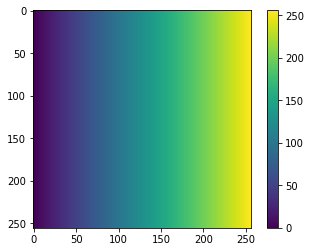

In [2]:
im_shape = (256, 256)
px_coords = RP.PixelCoordGrid(im_shape, extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
plt.imshow(px_coords[0])
plt.colorbar()

Based on this set of coordinates, ROIs can be defined by their center coordinates and their extent: $(x, y, dx, dy)$ or $(r, \theta, dr, d\theta)$. The resulting set of ROIs is stored as a list of binary masks one for each ROI.

```python
ROI_masks = RP.GenerateMasks(coords, grid, common_mask=None)
```

where:
- ```coords``` is a list of mask coordinates in the form ```[x0, x1, dx0, dx1]```
- ```grid``` is a grid of coordinates, as generated by ```RP.PixelCoordGrid```
- ```common_mask``` eventually contains a common mask with pixels to be excluded from all ROIs

A list of binary masks can also be visualized as an integer map, reporting the ROI index every pixel belongs to, using:

```python
RP.BinaryToIntegerMask(ROI_masks)
```

Note that regions of overlapping ROIs are not resolved by this visualization, but they are supported by ```ROIproc```, which uses independent binary masks for each ROI

DEBUG:root:4 binary masks created with shape (256, 256)


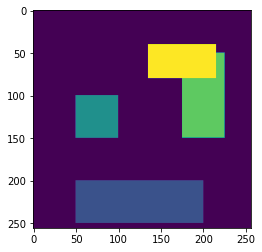

In [3]:
ROI_coords = [[125, 225, 150, 50], [75, 125, 50, 50], [200, 100, 50, 100], [175, 60, 80, 40]]
ROIs = RP.GenerateMasks(ROI_coords, px_coords)
plt.imshow(RP.BinaryToIntegerMask(ROIs))

The entire image can be tiled with ROIs using:

```python
ROI_grid, ROI_nodes = RP.GenerateROIgrid(px_coords, GridShape, coord_limits=None, common_mask=None)
```

where:
- ```px_coords``` is a grid of pixel coordinates, as generated by ```RP.PixelCoordGrid```
- ```GridShape``` is a couple ```(M,N)``` specifying the number of ROIs across each coordinate axis
- ```coord_limits``` eventually restricts the tiling to a subset of the entire space defined by its boundaries along each axis: ```[[min_x0, max_x0], [min_x1, max_x1]]```. If None, full axis span will be taken

DEBUG:root:16 binary masks created with shape (256, 256)


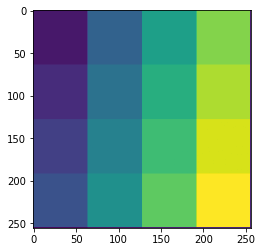

In [4]:
ROI_gridshape = (4, 4)
ROI_grid, ROI_nodes = RP.GenerateROIgrid(px_coords, ROI_gridshape)
plt.imshow(RP.BinaryToIntegerMask(ROI_grid))

### Processing ROIs

The core of a DLS analysis is to compute ROI-averaged statistics on image intensity $\langle I_p \rangle$. This is based on the function: 

```python
AvgRes, norm = RP.ROIAverage(image, ROImask, boolMask=False, weights=None, norm=None, masknans=False, dtype=float, evalFunc=None, evalParams={}, debug=False):
```

where:
- ```image```is either 2D image or 3D ndarray with list of images
- ```ROImask``` is either a list of 2D binary masks (if ```boolMask==True```) or a 2D int array with same size as image, with each pixel labeled with the index of the ROI it belongs to, 0-based (if ```boolMask==False```). In this case, each pixel can only belong to one ROI, and pixels not belonging to any ROI must be labeled with -1
- ```weights``` is a 2D float array, with the same shape as ```image```. If specified, the function computes a weighted average instead of a simple average.
- ```norm``` list of normalization factors (float), one per ROI. Equals the number of pixel belonging to each ROI if average is not weighted. If ```None``` (default), it is computed from ROImask. It can be passed as an argument to speed up the computation.
- ```masknans``` (bool). If true, assume the presence of NaNs in the array: mask them and don't count them in the normalization by setting their weight to zero. Set it to ```False``` if you are sure that there are no NaNs to improve calculation speed
- ```dtype``` datatype of the accumulator in which the elements are summed. If the accumulator is too small, np.sum generates overflow
- ```evalFunc``` if None, simple average will be computed. Otherwise, what will be averaged will be a function of the pixel values
- ```evalParams``` eventually specify additional parameters for evalFunc

The function returns:
- ```AvgRes```: If processing a single image (2D input): 1D float array with ROI-averaged data. If processing multiple images (3D input): 2D float array, one image per row, one ROI per column. If a bin contains NO DATA (e.g. empty ROI, or zero weights, or due to NaNs), it will have a NaN value because of the divide-by-sum-of-weights component.
- ```norm``` the normalization factor (sum of weights) for each ROI. If ```weights==None```, this is the number of pixels in the ROI

DEBUG:root:MIfile object created with filename ..\ROI_test\MI.raw
DEBUG:root:Now loading MIfile metadata (from filename: ..\ROI_test\MI_metadata.ini)
DEBUG:root:Loading config file ..\ROI_test\MI_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']


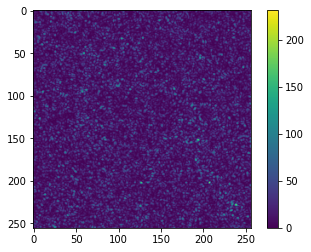

In [5]:
froot = r'..\ROI_test'
MIinput = MI.MIfile(os.path.join(froot, 'MI.raw'), os.path.join(froot, 'MI_metadata.ini'))
MIinput.OpenForReading()
im1 = MIinput.GetImage(0)
plt.imshow(im1)
plt.colorbar()

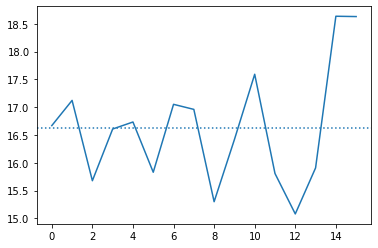

In [6]:
AvgRes, norm = RP.ROIAverage(im1, ROI_grid, boolMask=True)
plt.plot(AvgRes)
plt.axhline(np.mean(im1), ls=':')

To view it as a map:

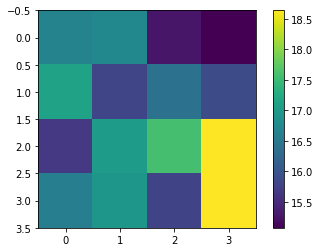

In [7]:
plt.imshow(AvgRes.reshape(ROI_gridshape).T)
plt.colorbar()

The same function can be used to compute image correlations $\langle I_p(t) I_p(t+\tau) \rangle$:

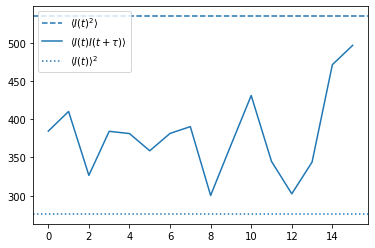

In [8]:
im2 = MIinput.GetImage(2)
XprodAvg, norm = RP.ROIAverage(im1*im2, ROI_grid, boolMask=True)
plt.axhline(np.mean(im1**2), ls='--', label=r'$\langle I(t)^2\rangle$')
plt.plot(XprodAvg, label=r'$\langle I(t)I(t+\tau)\rangle$')
plt.axhline(np.mean(im1)**2, ls=':', label=r'$\langle I(t)\rangle^2$')
plt.legend()

### The ROIproc class

The ```ROIproc``` class does this analysis on an input ```MIfile```. To initialize a ```ROIproc``` object:

```python
ROI_proc = RP.ROIproc(MIin, ROImasks, ROIcoords=None, imgTimes=None, expTimes=[1])
```

where:
- ```MIin``` is the input ```MIfile``` or ```MIstack``` to be processed.
- ```ROImasks``` is the list of binary masks Each mask is a 2D binary array with same shape as ```MIin.ImageShape()```. ```True``` values (nonzero) denote pixels that will be included in the analysis, ```False``` values (zeroes) will be excluded. If ```None```, all pixels will be included.
- ```ROIcoords``` eventually specifies a list of ROI coordinates, one element per ROI. Each element can be a scalar or a tuple
- ```imgTimes``` is a ```float``` array of length ```MIin.ImageNumber()```. i-th element will be the time of the image in physical units. If ```None```, time will be measured in image units.

**NOTE: Image times and exposure times**

In typical experiments, images are acquired at a constant rate (FPS), specified in the metadata of each MIfile (see tutorial 1). However, there are cases in which custom acquisition schemes may be used to enhance the sensitivity to both the fastest and the slowest dynamics. In these cases, the time at which each image has beed taken (```imgTimes```) needs to be provided. It is usually saved in an ASCII file accompanying the raw file with the images. If this is the case, image times can be extracted using:

```python
im_times = RP.LoadImageTimes(img_times_source, usecols=0, skiprows=1, root_folder=None, return_unique=False)
```

where:
- ```img_times_source``` is the file name or list of filenames. If several filenames are given, results will be concatenated 
- ```usecols``` is index of the column in the file containing image times
- ```skiprows``` is the number of rows to be skipped at the beginning of the file
- ```root_folder``` is the root folder path. If specified, img_times_source will be interpreted as a relative path
- ```return_unique``` : if ```True```, remove duplicates before returning result

In addition, because sometimes the dynamic range of a typical 8bit camera is not enough to properly measure speckle patterns with spatially-modulated intensities, where the intensity may vary of several orders of magnitude, the same speckle field is typically recorded using multiple exposure times.
Combining images taken at different exposure time in one unique spectrum requires knowledge of the exposure times (```expTimes```).

In [9]:
ROI_proc = RP.ROIproc(MIinput, ROIs)
ROI_proc

INFO:root:Set 4 valid ROIs
DEBUG:root:10 image times automatically generated from MI metadata (fps=10.0Hz)
DEBUG:root:Set one single exposure time: 1


<ROIproc object: MIfile (..\ROI_test\MI.raw) + 4 ROIs>

In [10]:
print(ROI_proc)


|-----------------|
|  ROIproc class: |
|-----------------+---------------
| Input           : MIfile (..\ROI_test\MI.raw), 10 images
| ROIs            : 4 (4 valid, 0 empty)
| Exposure times  : 1, from 1 to 1
|-----------------+---------------


The binary masks for the ROIs are stored in ```ROIproc.ROI_masks``` (or in its integer map form ```ROIproc.ROIs```):

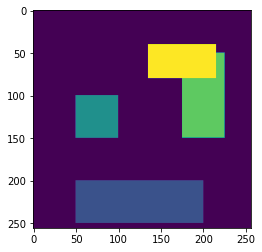

In [11]:
plt.imshow(RP.BinaryToIntegerMask(ROI_proc.ROI_masks))

```ROIproc``` stores also the area of each ROI, to speed up normalization of ```RP.ROIAverage```. It is saved in ```ROIproc.ROI_maskSizes```:

In [12]:
ROI_proc.ROI_maskSizes

array([7500, 2500, 5000, 3200])

To optimize computation, ```ROIproc``` stores the coordinates of the smallest box enclosing all ROIs in the form ```[min_row, min_col, max_row, max_col]``` in the variable ```ROIproc.ROIboundingBox``` or equivalently, in the form ```[topleftx, toplefty, width, height]``` in the variable ```self.CropROIbb```:

array([ 40,  50, 250, 225], dtype=int64)

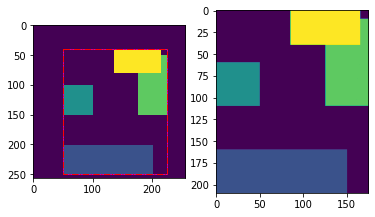

In [13]:
ROIbb = ROI_proc.BoundingBox
ROIbb2 = ROI_proc.CropROIbb
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(ROI_proc.ROIs, interpolation='none', extent=(0, ROI_proc.ROIs.shape[1], ROI_proc.ROIs.shape[0], 0))
ax[0].add_patch(patches.Rectangle((ROIbb[1], ROIbb[0]), ROIbb[3]-ROIbb[1], ROIbb[2]-ROIbb[0], edgecolor='m', facecolor='none'))
ax[0].add_patch(patches.Rectangle((ROIbb2[0], ROIbb2[1]), ROIbb2[2], ROIbb2[3], ls='-.', edgecolor='r', facecolor='none'))
ax[1].imshow(ROI_proc.ROIs[ROIbb[0]:ROIbb[2],ROIbb[1]:ROIbb[3]])
ROIbb

When this bounding box is specified, ```ROIproc``` reads the ROI instead of the full image when its functions ```ROIproc.GetImage(image_idx, buffer)``` and ```ROIproc.ReadMI()``` are called.

In addition, ```ROIproc``` stores the bounding boxes of every ROI in the form ```[min_row, min_col, max_row, max_col]```, where coordinates are defined *relative to the cropped image*, in the variable ```ROIproc.ROIboundingBoxes```:

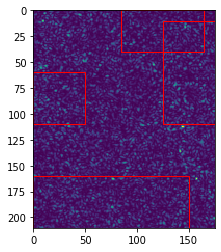

In [14]:
im1_crop = ROI_proc.GetImage(0)
fig, ax = plt.subplots()
ax.imshow(im1_crop, interpolation='none', extent=(0, ROI_proc.CropROIbb[2], ROI_proc.CropROIbb[3], 0))
for ridx in range(ROI_proc.CountROIs()):
    _rbb = ROI_proc.ROIboundingBoxes[ridx]
    ax.add_patch(patches.Rectangle((_rbb[1], _rbb[0]), _rbb[3]-_rbb[1], _rbb[2]-_rbb[0], edgecolor='r', facecolor='none'))

To further speed up the computation, these bounding boxes are given to the ```ROIAverage``` function, which then works on subsets of the whole image only. Because ```ROIproc``` contains both the ROIs and the input MIfile, computing ROIaverages only requires to specify the list of indexes of images to be processed. This is done in the function:
```python
AvgRes = ROIproc.ROIaverageIntensity(stack1, ROImasks=None, masks_isBool=False, no_buffer=False, imgs=None):
```

which is a special case of the more general function (with ```stack2==None```):
```python
AvgRes = ROIproc.ROIaverageProduct(stack1, stack2=None, ROImasks=None, masks_isBool=False, no_buffer=False, imgs=None):
```

where:

- ```stack1``` is a list of indexes. Images will be either read by MIinput or retrieved from img_buffer
- ```stack2``` is None, or list of indexes
         - if None: function will return averages of single images (in stack1)
         - if list: length should be the same as stack1
- ```ROImasks``` : 2D int array or 3D bool array: masks associating each pixel to a ROI
         - if 2D int array: pixel value will denote which ROI the pixel belongs to
         - if 3D bool array: i-th 2D array willbe True for pixels belonging to i-th ROI
         shape of each 2D mask has to match the image shape
         if None, self.ROIs will be used (which is of type int by default)
- ```masks_isBool``` : True or False to indicate that ROImasks is of bool or int type, respectively
- ```no_buffer``` : if True, avoid reading all images to a buffer, but read images one by one
            (dumping them afterwards)
- ```imgs``` : None or 3D array with buffered images. If None, images will be read from MIinput

The function returns a 2D array, with as many rows as the number of images and as many columns as the number of ROIs. ```AvgRes[i,j]``` is the average of i-th image on j-th ROI

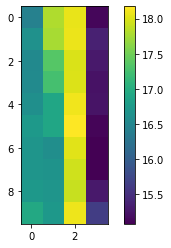

In [21]:
AvgRes = ROI_proc.ROIaverageIntensity()
plt.imshow(AvgRes)
plt.colorbar()

### Computing correlations

Dynamic light scattering (DLS) measures the two-times correlation of the detected intensity: $c(t, \tau)\propto\langle I_p(t) I_p(t+\tau) \rangle$, where the average $\langle \cdots \rangle$ is computed on pixels belonging to the same ROI. This can be computed using ```ROI_proc.ROIaverageProduct``` defined above:

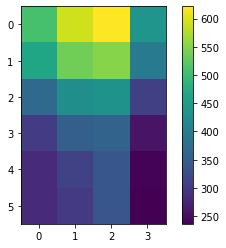

In [22]:
tau_list = [0,1,2,3,4,5]
AvgRes_num = ROI_proc.ROIaverageProduct([0]*len(tau_list), tau_list)
plt.imshow(AvgRes_num)
plt.colorbar()

### Normalization

Each column is a ROI, $\tau$ increases going downwards. The starting point for each column depende on $\langle I_p \rangle$, which is why it is interesting to normalize the correlation function. In principle, this is done using $\langle I_p(t) \rangle\langle I_p(t+\tau) \rangle$

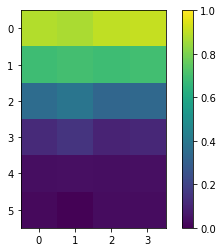

In [23]:
AvgRes_den = ROI_proc.ROIaverageIntensity(tau_list)
AvgRes_corr = np.empty_like(AvgRes_num)
for tau_idx in range(AvgRes_num.shape[0]):
    AvgRes_corr[tau_idx] = AvgRes_num[tau_idx]/(AvgRes_den[0]*AvgRes_den[tau_idx]) - 1
plt.imshow(AvgRes_corr, vmin=0, vmax=1)
plt.colorbar()

Normalization using $\langle I_p(t) \rangle\langle I_p(t+\tau) \rangle$ is not perfect, for some reason. For this reason, one can define a normalized correlation as in Duri et al., PRE 2005: $\tilde{c}(t, \tau)=2c(t, \tau)/[c(t, 0)+c(t+\tau, 0)]$.

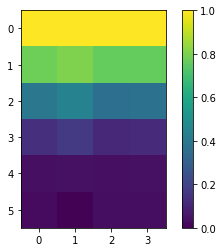

In [24]:
AvgRes_corrNorm = np.empty_like(AvgRes_corr)
for tau_idx in range(AvgRes_num.shape[0]):
    AvgRes_corrNorm[tau_idx] = AvgRes_corr[tau_idx]/AvgRes_corr[0]
plt.imshow(AvgRes_corrNorm, vmin=0, vmax=1)
plt.colorbar()

This multi-step analysis can be run through the function:
```python
ROIproc.doDLS(saveFolder, lagtimes, reftimes='all', no_buffer=False, force_SLS=True, save_transposed=False)
```

where:

- ```saveFolder```: folder path to export analysis output
- ```lagtimes```: ```'all'``` or list of ```int```.
    - If ```'all'```, all available lagtimes will be processed
    - Otherwise, only specified lagtimes will be processed
- ```reftimes```: ```'all'``` or list of ```int```.
    - If ```'all'```, all reference times will be used
    - Otherwise, specialize the analysis to a subset of reference times specified in the list
- ```no_buffer```: If ```True```, avoid reading full MIfile to RAM. It saves memory but slows down processing.
- ```force_SLS```: If ```False```, program will load previously computed SLS results if available.
- ```save_transposed```: specifies the format of correlation timetrace output
    - if ```False```, classic cI output: one line per reference time, one column per time delay
    - if ```True```, transposed output: one line per time delay, one column per reference time

In [25]:
%%time
ROI_proc.doDLS(os.path.join(froot, 'out2'), lagtimes='all', reftimes='all', no_buffer=False, force_SLS=True, save_transposed=False)

INFO:root:ROIproc.doDLS Analysis started! Input data is 10 images (10 times, 1 exposure times)
INFO:root:Analysis will resolve 4 ROIs and DLS will be performed on 10 reference times and 10 lagtimes. Output will be saved in folder ..\ROI_test\out2
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (10, 1, 4)), Iavg data (shape: (10, 4)), exptime data (shape: (10, 4)), buffer images (shape (10, 210, 175))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 10 time points, 10 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 10, 1] (10 images)
INFO:root:Contrast (d0) processed
INFO:root:Lagtime 1/9 (d1) completed
INFO:root:Lagtime 2/9 (d2) completed
INFO:root:Lagtime 3/9 (d3) completed
INFO:root:Lagtime 4/9 (d4) completed
INFO:root:Lagtime 5/9 (d5) completed
INFO:root:Lagtime 6/9 (d6) completed
INFO:root:Lagtime 7/9 (d7) completed
INFO:root:Lagtime 8/9 (d8) 

Created folder: ..\ROI_test\out2
Wall time: 83.3 ms


Results can be visualized as correlation timetraces. Let's define convenience visualization functions:

In [20]:
def PlotContrast(CIlist, times=None, figsize=(10,8), plot_fmt='.-', cmap=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if cmap is not None:
        color.cycle_cmap(len(CIlist), cmap=cmap, ax=ax)
    for i in range(len(CIlist)):
        ax.plot(times, CIlist[i][:,0], plot_fmt, label='ROI{0}'.format(i))
    ax.set_xlabel('t')
    ax.set_ylabel('cI')
    ax.legend(ncol=2)
    return fig, ax

def PlotCIs(CIdata, lags=None, times=None, lag_sel=None, figsize=(10,8), plot_fmt='.-', cmap=None):
    '''
    Plots correlation timetraces
    
    Parameters
    ----------
    - CIdata: 3D array. CIdata[i,j,k] is the correlation of j-th time and k-th time delay for i-th ROI
    - lags: list or 1D array, with all time delays. If None, time delays will be assumed to be 0,1,...,N-1
    - lag_sel: list of indexes of lagtimes to be plotted. If None, all time delays will be plotted
    - cmap: matplotlib color map. For instance: mpl.cm.jet
    '''
    fig, ax = plt.subplots(figsize=figsize)
    if lags is None:
        lags = np.arange(CIdata.shape[1])
    else:
        lags = np.asarray(lags)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if lag_sel is None:
        lag_sel = np.asarray(range(len(lags)), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(lag_sel), cmap=cmap, ax=ax)
    for lidx in lag_sel:
        ax.plot(times, CIdata[:,lidx], plot_fmt, label='d{0}'.format(lags[lidx]))
    ax.set_xlabel('t')
    ax.set_ylabel('cI')
    ax.legend(ncol=2)
    return fig, ax

def PlotCorrFuncs(CorrFuncData, lags, times=None, t_sel=None, figsize=(10,8), plot_fmt='.-', cmap=None, legend=True, 
                  logx=True, logy=False, logG2M1=False, baseline=0, start=1, min_corrval=None, save_file=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if t_sel is None:
        t_sel = np.asarray(range(CorrFuncData.shape[0]), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(t_sel), cmap=cmap, ax=ax)
    if save_file is not None:
        save_data = []
        save_hdr=''
    for tidx in t_sel:
        if start=='first':
            start_val = CorrFuncData[tidx][1]
        else:
            start_val=start
        to_plot = (CorrFuncData[tidx]-baseline)/(start_val-baseline)
        if min_corrval is not None:
            to_plot[to_plot<min_corrval] = np.nan
        if logG2M1:
            to_plot = -np.log(to_plot)
        ax.plot(lags[tidx], to_plot, plot_fmt, label='t{0}'.format(times[tidx]))
        if save_file is not None:
            save_data.append(lags[tidx])
            save_data.append(to_plot)
            if save_hdr!='':
                save_hdr += '\t'
            save_hdr += 't' + str(times[tidx])
            if logG2M1:
                save_hdr += '\t-ln(g2-1)(t={0})'.format(times[tidx])
            else:
                save_hdr += '\tg2-1(t={0})'.format(times[tidx])
    ax.set_xlabel(r'$\tau$')
    if logG2M1:
        ax.set_ylabel(r'$-\ln(g_2-1)$')
    else:
        ax.set_ylabel(r'$g_2-1$')
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    if legend:
        ax.legend(ncol=2)
    if save_file is not None:
        np.savetxt(save_file, np.asarray(save_data).T, delimiter='\t', header=save_hdr)
    return fig, ax

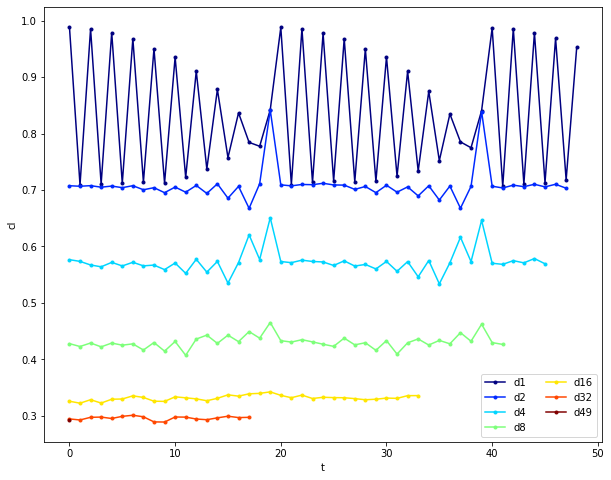

In [21]:
fig, ax = PlotCIs(all_cIs[4], lags=tau_list, lag_sel=list(range(1,len(tau_list))), cmap=mpl.cm.jet)

### 2.4. Timetrace averaging and non-uniform acquisition schemes

If the process was pseudo stationary and images were taken at constant frame rate, one could simply average these correlation traces to get a correlation function. Here, the time interval between two images is not constant, and this time averaging requires knowledge of the time each frame was taken. Image times can be loaded from file using
```python
imgTimes = SALS.LoadImageTimes(img_times_source, root_folder=None, usecols=0, skiprows=1, default_value=None, squeeze_res=True)
```

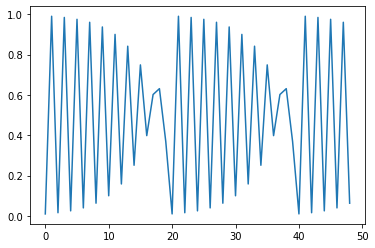

In [3]:
imgTimes = LS.LoadImageTimes('MI_DLS_imgTimes.dat', root_folder=froot, usecols=3, skiprows=1, default_value=None, squeeze_res=True)
plt.plot(np.diff(imgTimes))

Once correlation data and image times are known, averaging of correlation timetraces can be done by calling
```python
AvgCorr, CorrLags = SALS.AverageCorrTimetrace(CorrData, ImageTimes, Lagtimes_idxlist, average_T=None)
```

where:

- ```CorrData``` is a 2D array. Element [i,j] is $\tilde{c}(t_i, \tau_j)$
- ```ImageTimes``` is 1D array of ```float```. i-th element is the physical time at which i-th image was taken
- ```Lagtimes_idxlist``` is 1D array of ```int```. i-th element is the lagtime, in image units
- ```average_T``` is ```int``` or ```None```. When averaging over time, resolve the average on chunks of ```average_T``` images each.
                 If None, result will be average on the whole stack

This function returns:

- ```g2m1```: 2D array. Element [i,j] represents j-th lag time and i-th time-resolved chunk
- ```g2m1_lags```: 2D array. It contains the time delays, in physical units, of the respective correlation data

NameError: name 'all_cIs' is not defined

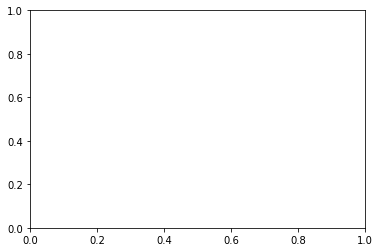

In [4]:
fig, ax = plt.subplots()
for i in range(all_cIs.shape[0]):
    g2m1, g2m1_lags = LS.AverageCorrTimetrace(all_cIs[i], imgTimes, tau_list, average_T=None)
    ax.plot(g2m1_lags[0], g2m1[0], '-o', label='ROI{0}'.format(i))
ax.set_xscale('log')
ax.legend()

### 2.5. Complete data analysis process

All the parameters of the analysis can be stored in the ```SALS_analyzer``` object, and complete analysis can be simply run by calling:
```python
SALS_analyzer.Run(self, no_buffer=False)
```
where ```no_buffer``` is a parameter that dictates whether all images are read into a buffer and then processed (```no_buffer==False```, more time efficient, high memory consumption), or rather read as needed and dumped afterwards (```no_buffer==False```, less time efficient, lower memory consumption)

In [ ]:
SALS_analyzer.Run(doDLS=True, no_buffer=False)

Analysis result is saved in ```SALS_analyzer.outFolder```. 
Several output files will be generated:
- ROI selection
    - **ROIcoords.dat**: polar coordinates of ROIs
    - **ROImask.raw**: raw image (data type: 32bit integer, signed, no header, same shape as original image). Pixel value is the index of the ROI that pixel belongs to (0-based, as in the DLS filenames), and -1 for pixel not belonging to any ROI
- SLS output:
    - **I_r_raw.dat**: ROI-averaged image intensity for each input image (one per exposure time, if multiple exposure times are present). Ageraged intensity is already normalized by the exposure time
    - **exptimes.dat**: optimal exposure time for each ROI and acquired image
    - **I_r.dat**: ROI-averaged optimal image intensity for each input image (obtained selecting the optimal exposure time reported in exptimes.dat)
- DLS output:
    - **cI_ROIxxx_eyy.dat**: correlation timetraces, where xxx is the ROI index and yy the exposure time index
    - **g2m1_ROIxxx_eyy.dat**: time-averaged correlation functions

The last step of DLS analysis (the time averaging of the correlation timetraces) can be repeated after the analysis is completed, using:
```python
SALS_analyzer.AverageG2M1(cI_file, average_T=None)
```

In [ ]:
LS.AverageG2M1(os.path.join(SALS_analyzer.outFolder, 'cI_ROI005_e00.dat'), average_T=20)

## 3. Postprocess

### 3.1 Loading SLS results

In [ ]:
SLSdata, rarr, phiarr, times = LS.OpenSLS(r'D:\steaime\Data\SALS\210202\out_stack_corr', open_raw=False)

In [ ]:
def PlotSLS(SLSdata, rs, times=None, timesel=None, OptBkg=None, figsize=(10,8), plot_fmt='.-', cmap=None, legend=True, funcfit=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(SLSdata.shape[1])
    if timesel is None:
        timesel = np.asarray(range(len(times)), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(timesel), cmap=cmap, ax=ax)
    for tidx in timesel:
        if OptBkg is None:
            to_plot = SLSdata[:,tidx]
        else:
            to_plot = SLSdata[:,tidx] - OptBkg
        ax.plot(rs, to_plot, plot_fmt, label='t{0}'.format(times[tidx]))
    if funcfit is not None:
        for tidx in timesel:
            if OptBkg is None:
                to_fit = SLSdata[:,tidx]
            else:
                to_fit = SLSdata[:,tidx] - OptBkg
            popt, _ = optimize.curve_fit(funcfit, rs, to_fit)
            ax.plot(rs, funcfit(rs, *popt), '--', label='t{0}_fit'.format(times[tidx]))
    ax.set_xlabel('r')
    ax.set_ylabel('I')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if legend:
        ax.legend(ncol=2)
    return fig, ax

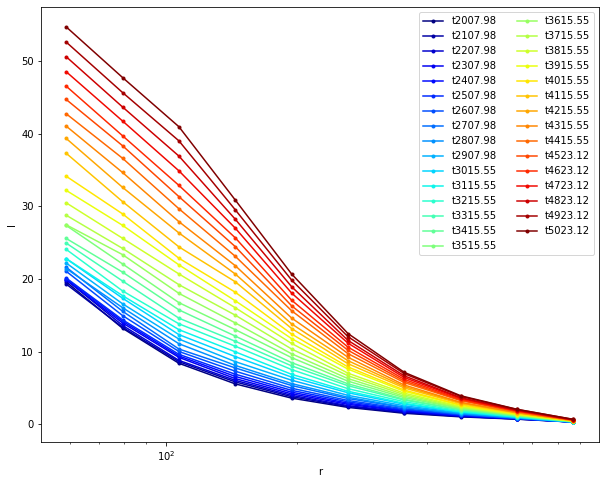

In [69]:
fig, ax = PlotSLS(SLSdata, rarr, times=times, timesel=list(range(400, SLSdata.shape[1]//13, 20)), cmap=mpl.cm.jet)#, OptBkg=SLSdata[:,380]
ax.set_yscale('linear')
#ax.set_ylim([0.1, 40])

### 3.2 Loading DLS results

In [2]:
cIs, times, lags, ROI_list, exptime_list = LS.OpenCIs(r'D:\steaime\Data\220711_Chitosan\HighConc\Sample\out_stack_dls')
times = times[0]
lags = lags[0]

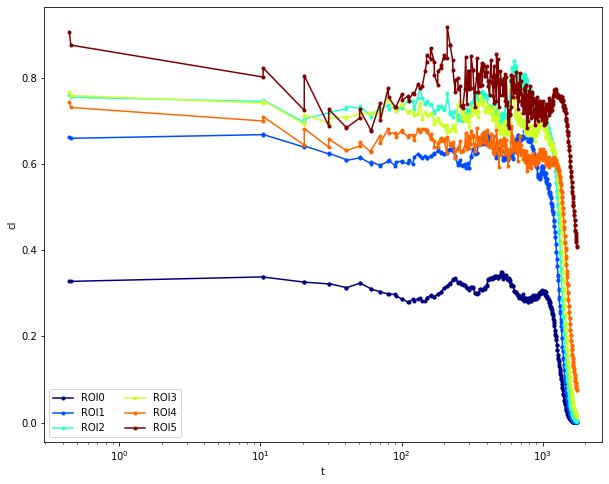

In [5]:
fig, ax = PlotContrast(cIs, times, cmap=mpl.cm.jet)
ax.set_xscale('log')
#ax.set_xlim([100, 100000])

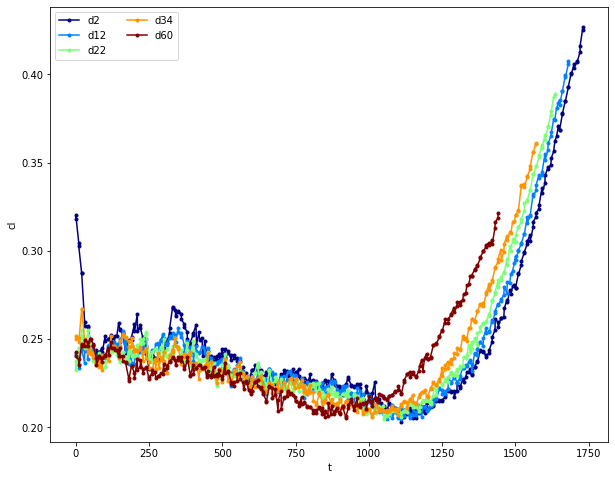

In [8]:
fig, ax = PlotCIs(cIs[5], lags, times, lag_sel=list(range(2, len(lags), 5)), cmap=mpl.cm.jet)

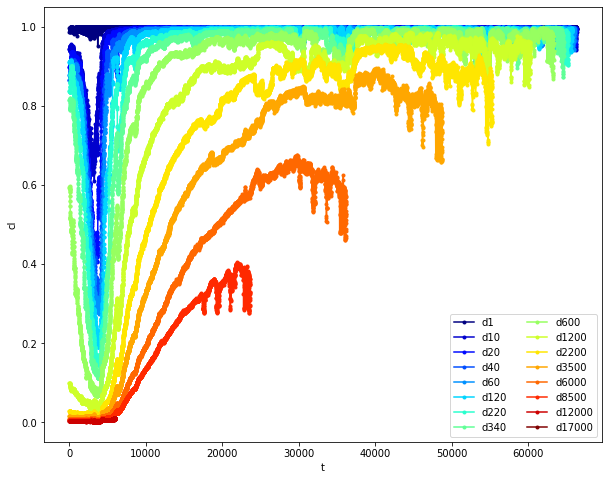

In [36]:
fig, ax = PlotCIs(cIs[2], lags, times, lag_sel=list(range(1, len(lags), 5)), cmap=mpl.cm.jet)

In [5]:
froot = r'D:\steaime\Data\SALS\210202\out_stack_corr'
g2m1s, lags, times, ROI_list, exptime_list = LS.OpenG2M1s(froot)#SALS_analyzer.outFolder)
times = times[0]
lags = lags[0]

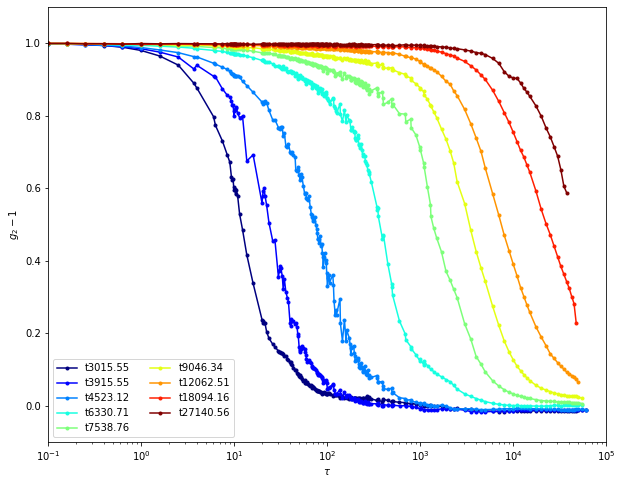

In [24]:
baselines = [0, 0, 0, 0, 0.03, 0.06, 0.07, 0.09, 0, 0]
idx = 7
corr_logy = False
save_file = None if corr_logy else os.path.join(froot, 'g2m1_ROI' + str(idx).zfill(3) + '_corr.dat')
fig, ax= PlotCorrFuncs(g2m1s[idx], lags, times, t_sel=[10, 13, 15, 21, 25, 30, 40, 60, 90], cmap=mpl.cm.jet, logG2M1=corr_logy, logy=corr_logy, 
                       baseline=baselines[idx], start='first', plot_fmt='.-', legend=False, min_corrval=None, save_file=save_file)
if corr_logy:
    ax.set_ylim([1e-4, 3])
else:
    ax.set_ylim([-0.1, 1.1])
    #ax.hlines([0], xmin=0.1, xmax=1e5)
ax.set_xlim([0.1, 1e5])
ax.legend(ncol=2)